# Circle Detection
Soooo for some reason the circle detection isnt working as well anymore. I must have modified some parameters and then forgotten about it. One thing for certain though is that for thick rings the contours are not as good. Edge detection will be necessary. 


Some useful links:  
https://stackoverflow.com/questions/13070075/how-to-detect-circles-accurately  
http://opencvpython.blogspot.ca/2012/06/contours-2-brotherhood.html  
https://stackoverflow.com/questions/32287032/circular-hough-transform-misses-circles  
http://layer0.authentise.com/detecting-circular-shapes-using-contours.html  

Numpy/OpenCV formatting/processing links:  
https://stackoverflow.com/questions/7587490/converting-numpy-array-to-opencv-array  
https://stackoverflow.com/questions/8647024/how-to-apply-a-disc-shaped-mask-to-a-numpy-array  

In [1]:
import glob
import cv2
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import utils.make_density_map as mdm

In [2]:
ext = "rings"    #rings or circlerings
train_data=np.load('training_set/train_data_%s_sample.npy'%ext).astype('float32')
train_target=np.load('training_set/train_target_%s_sample.npy'%ext).astype('float32')
test_data=np.load('test_set/test_data_%s_sample.npy'%ext).astype('float32')
test_target=np.load('test_set/test_target_%s_sample.npy'%ext).astype('float32')

In [2]:
def get_im_cv2(path, img_width, img_height):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_width, img_height))#, cv2.INTER_LINEAR)
    return resized

def load_data(path, data_type, img_width, img_height):
    X, X_id, y = [], [], []
    minpix = 2                                  #minimum number of pixels for crater to count
    files = glob.glob('%s*.png'%path)
    print "number of %s files are: %d"%(data_type,len(files))
    for i,fl in enumerate(files):
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl,img_width,img_height) / 255.
        
        #experimenting with bigger contrast
        img[img > 0.] = 1. - img[img > 0.] 
        minn, maxx = np.min(img[img>0]), np.max(img[img>0])
        low, hi = 0.1, 1
        img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn)
        X.append(img)
        X_id.append(fl)
        
        csv = pd.read_csv('%s.csv'%fl.split('.png')[0])
        csv.drop( np.where(csv["Diameter (pix)"] < minpix)[0], inplace=True )
        target = mdm.make_mask(csv, img, binary=True, truncate=True, rings=True)
        #target = mdm.make_circlering_mask(csv, img, binary=True, truncate=True)
        #target = mdm.make_mask(csv, img, binary=True, rings=True, ringwidth=1, truncate=True)
        y.append(target)
    return  X, y, X_id

def read_and_normalize_data(path, img_width, img_height, data_flag):
    if data_flag == 0:
        data_type = 'train'
    elif data_flag == 1:
        data_type = 'test'
    data, target, id = load_data(path, data_type, img_width, img_height)
    data = np.array(data).astype('float32')     #convert to numpy, convert to float
    print('%s shape:'%data_type, data.shape)
    return data, target, id

train_data, train_target, train_id = read_and_normalize_data('training_set/', 300, 300, 0)
test_data, test_target, test_id = read_and_normalize_data('test_set/', 300, 300, 0)

number of train files are: 90
('train shape:', (90, 300, 300, 3))
number of train files are: 26
('train shape:', (26, 300, 300, 3))


## Recognize Circles

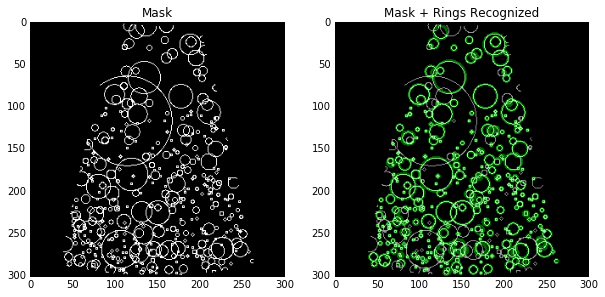

In [10]:
#working best!
img_i=4
t = train_target[img_i].copy()
t = t.astype(np.uint8)                      #findcontours and Canny only take uint8. 
imgshape = t.shape[0]

#hyperparameters
thresh = 2         #2-3 seems to work well
mask_thickness = 2

center, radius = [], []
cimg = cv2.cvtColor(t, cv2.COLOR_GRAY2BGR) 
image, contours, hierarchy = cv2.findContours(t, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for cnt in contours:
    (x,y),r = cv2.minEnclosingCircle(cnt)
    x,y,r = int(round(x)), int(round(y)), int(round(r))          #center/radius of circle
    yy,xx = np.ogrid[-y:imgshape-y, -x:imgshape-x]               #locate centroid of ring in image
    mask_ring = np.abs(yy*yy + xx*xx - r*r)/r <= mask_thickness  #create a ring mask
    if np.abs(np.sum(t[mask_ring]) - 2*np.pi*r)/r < thresh:      #check if ring mask corresponds to real ring in image
        cv2.circle(cimg,(x,y),r,(0,255,0),thickness=2)           #draw circle
        center.append((x,y)); radius.append(r)

f, (ax1, ax2) = plt.subplots(1,2, figsize=[10, 8])
ax1.imshow(train_target[img_i], origin='upper', cmap="Greys_r")
ax1.set_title("Mask")
ax2.imshow(train_target[img_i], origin='upper', cmap="Greys_r")
ax2.imshow(cimg, origin='upper', cmap="Greys_r",alpha=0.4)
ax2.set_title("Mask + Rings Recognized")
plt.savefig("output_dir/images/circle_recog%d.png"%img_i)

## Recognize circles from FCN output images (working pretty well)
I think ultimately you want to be trying the FCN outputted target images to the method above, but you'll first need to likely do a rounding of values > threshold = 1 (integer), values < threshold = 0.

In [5]:
#Saves image with no border - https://fengl.org/2014/07/09/matplotlib-savefig-without-borderframe/
def save_image(data, cm, fn):
    sizes = np.shape(data)
    height = float(sizes[0])
    width = float(sizes[1])
     
    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
 
    ax.imshow(data, cmap=cm)
    plt.savefig(fn, dpi = height) 

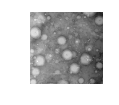

In [8]:
#save as image with no border first
i=14
cmap = "Greys_r"
filename = 'output_dir/circle_test.png'
save_image(test_data[i], cmap, filename)

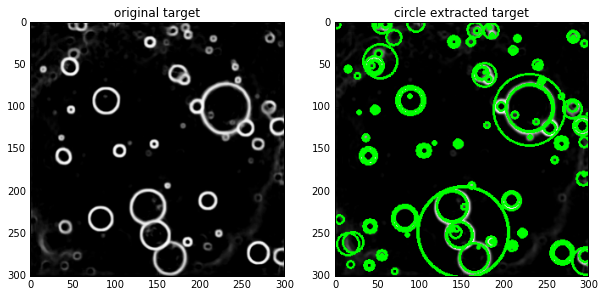

In [10]:
filename = "output_dir/images/FCNforkskip_rings_FL15_4_target.png"
img = cv2.imread(filename,0)
cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
edge_detected_image = cv2.Canny(img, 75, 200)
image, contours, hierarchy = cv2.findContours(edge_detected_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

cen, rad = [], []
for cnt in contours:
    (x,y),radius = cv2.minEnclosingCircle(cnt)
    center = (int(x),int(y))
    radius = int(radius)
    cv2.circle(cimg,center,radius,(0,255,0),thickness=2)
    #cv2.circle(cimg,center,2,(0,0,255),thickness=3)
    cen.append(center); rad.append(radius)

f, (ax1, ax2) = plt.subplots(1,2, figsize=[10, 8])
ax1.imshow(img, origin='upper', cmap="Greys_r")
ax1.set_title("original target")
ax2.imshow(cimg, origin='upper', cmap="Greys_r")
ax2.set_title("circle extracted target")
plt.savefig("%s_hough.png"%filename.split("_target.png")[0])

## Scratch

In [1]:
#SCRATCH - method 2 - works, but not quite as well as the other one.
#https://stackoverflow.com/questions/7587490/converting-numpy-array-to-opencv-array
#https://stackoverflow.com/questions/8647024/how-to-apply-a-disc-shaped-mask-to-a-numpy-array
#http://www.pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/  

img_i=10
t = train_target[img_i].astype(np.uint8)                 #findcontours and Canny only take uint8. 

center, radius = [], []
cimg = cv2.cvtColor(t, cv2.COLOR_GRAY2BGR) 

#edge_detected_image = cv2.Canny(cimg, 75, 200)
image, contours, hierarchy = cv2.findContours(t, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for cnt in contours:
    (x,y),r = cv2.minEnclosingCircle(cnt)
    x,y,r = int(round(x)), int(round(y)), int(round(r))                       #center and radius of circle
    #x,y,r = int(x), int(y), int(r)
    if r>20:
        print "%d, %d, %d"%(x, y, r)
    mask = np.zeros((t.shape[0],t.shape[1]))
    cv2.circle(mask, (x,y), r, color=1, thickness=1)
    diff = mask - t
    diff[diff<0] = 0
    if np.sum(diff) <= r: 
        cv2.circle(cimg,(x,y),r,(0,255,0),thickness=2)   #draw circle
        center.append((x,y)); radius.append(r)

plt.imshow(train_target[img_i], origin='upper', cmap="Greys_r")
plt.imshow(cimg, origin='upper', cmap="Greys_r",alpha=0.4)
plt.title("Mask + Rings Recognized")

NameError: name 'train_target' is not defined

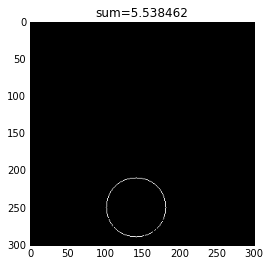

In [111]:
#testing method 2
x,y,r= 141, 249, 39
n = 300

t = train_target[img_i].astype(np.uint8)
mask = np.zeros((n,n))
cv2.circle(mask, (x,y), r+1, 1,1)
diff = mask - t
diff[diff<0] = 0
plt.imshow(diff, origin='upper', cmap="Greys_r")
plt.title('sum=%f'%(np.sum(diff)/float(r)))

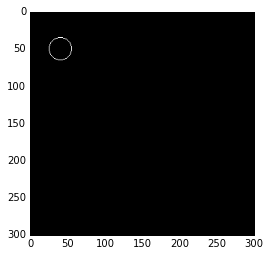

In [38]:
#basic (method 1)
y, x = 50, 40
n = 300
r = 15

yy,xx = np.ogrid[-y:n-y, -x:n-x]
mask = np.abs(xx*xx + yy*yy -r*r) <= r

array = np.zeros((n, n))
array[mask] = 1
plt.imshow(array, origin='upper', cmap="Greys_r")

0.437676093503
0.875352187005
0.0
0.891267681315
0.0
0.875352187005
0.0
0.905958906831
0.517253565049
0.88147353097
0.0
0.623356860443
0.763943726841
0.909456817668


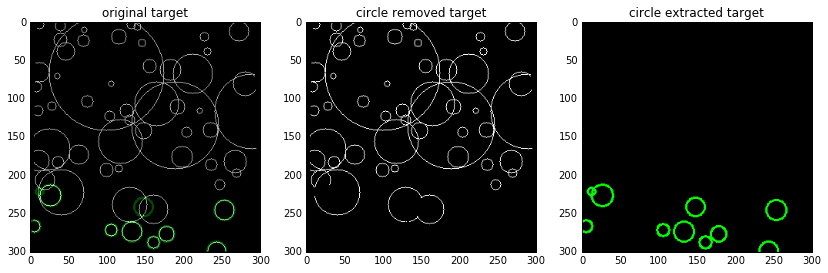

In [25]:
#https://stackoverflow.com/questions/7587490/converting-numpy-array-to-opencv-array
#https://stackoverflow.com/questions/8647024/how-to-apply-a-disc-shaped-mask-to-a-numpy-array

img_i=0
t = train_target[img_i].copy()
t = t.astype(np.uint8)                      #findcontours and Canny only take uint8. 
imgshape = t.shape[0]

r_iter = [2,15,50]                #iterate over radii scales - need to fine tune
center, radius = [], []
cimg = cv2.cvtColor(t, cv2.COLOR_GRAY2BGR) 

count = 0

for i in range(1): 
    #edge_detected_image = cv2.Canny(cimg, 75, 200)
    image, contours, hierarchy = cv2.findContours(t, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        (x,y),r = cv2.minEnclosingCircle(cnt)
        x,y,r = int(x), int(y), int(r) #center and radius of circle
        if (r > r_iter[i]) and (r < r_iter[i+1]):
            yy,xx = np.ogrid[-y:imgshape-y, -x:imgshape-x]
            mask = yy*yy + xx*xx - r*r <= 1
            print np.sum(t[mask])/(2*np.pi*r)
            count += 1
            
            t[mask] = 0
            cv2.circle(cimg,(x,y),r,(0,255,0),thickness=2)
            #cv2.circle(cimg,cen,2,(0,0,255),thickness=3)
            center.append((x,y)); radius.append(r)
            if count > 13:
                break
            
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[14, 8])
ax1.imshow(train_target[img_i], origin='upper', cmap="Greys_r")
ax1.imshow(cimg, origin='upper', cmap="Greys_r",alpha=0.3)
ax1.set_title("original target")
ax2.imshow(t, origin='upper', cmap="Greys_r")
ax2.set_title("circle removed target")
ax3.imshow(cimg, origin='upper', cmap="Greys_r")
ax3.set_title("circle extracted target")

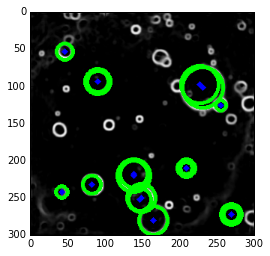

In [7]:
#http://www.pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/
#https://stackoverflow.com/questions/32287032/circular-hough-transform-misses-circles

img = cv2.imread(filename,0)
#img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

radii = np.arange(1,200,5)

#Hough circles
for i in range(len(radii)-1):
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,5,param1=25,param2=30,minRadius=radii[i],maxRadius=radii[i+1])
    if circles is None: # Skip if no circles are detected - Change here
        continue
    
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),thickness=3)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),thickness=3)
        
plt.imshow(cimg, origin='upper', cmap="Greys_r")

In [52]:
#contours
#https://stackoverflow.com/questions/25504964/opencv-python-valueerror-too-many-values-to-unpack
ret,thresh = cv2.threshold(img,127,255,0)
image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
image = cv2.drawContours(image, contours, -1, (0,255,0), 3)

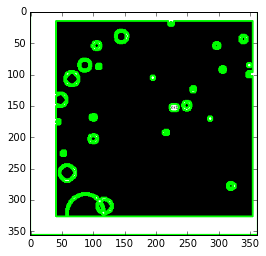

In [38]:
cimg2 = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
image, contours, hierarchy = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
cimg2 = cv2.drawContours(cimg2, contours, -1, color=(0,255,0), thickness=2)
plt.imshow(cimg2, origin='upper', cmap="Greys_r")

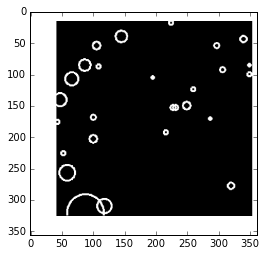

In [28]:
#
img = cv2.imread('output_dir/circle_test.png',0)
_, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
contour_list = []
for contour in contours:
    approx = cv2.approxPolyDP(contour,0.1*cv2.arcLength(contour,True),True)
    area = cv2.contourArea(contour)
    if ((len(approx) > 8) & (len(approx) < 23) & (area > 30) ):
        contour_list.append(contour)

circles=cv2.drawContours(img, contour_list,  -1, (0,255,0), thickness=2)
plt.imshow(circles, origin='upper', cmap="Greys_r")

NameError: name 'cimg' is not defined

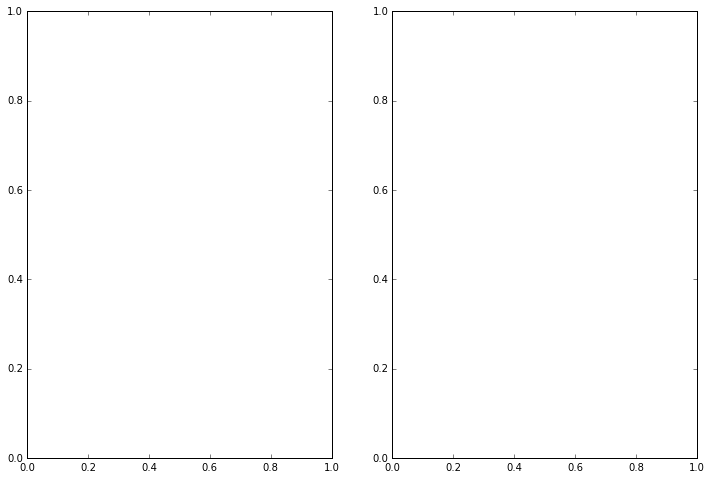

In [5]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=[12, 8])
ax1.imshow(cimg, origin='upper', cmap="Greys_r")
ax2.imshow(edge_detected_image, origin='upper', cmap="Greys_r")

In [90]:
cimg2 = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Find contours
contours,_ = cv2.findContours(255 - img, cv2.RETR_LIST, cv.CV_CHAIN_APPROX_NONE)

# Draw all detected contours on image in green with a thickness of 1 pixel
cv2.drawContours(cimg2, contours, -1, color=(0,255,0), thickness=1)

AttributeError: 'module' object has no attribute 'CV_CHAIN_APPROX_NONE'